from https://gist.github.com/alexbw/1867612 and https://stackoverflow.com/questions/25581263/kalman-filter-behaviour

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [49]:
Q=0
R=0
A=0
H=0
K=0
P=0
X=0

def kalman_init(state_dim, obs_dim):
    global Q
    global R
    global A
    global H
    global K
    global P
    global X
    Q = np.matrix( np.eye(state_dim)*1e-4 ) # Process noise
    R = np.matrix( np.eye(obs_dim)*0.01 ) # Observation noise
    A = np.matrix( np.eye(state_dim) ) # Transition matrix
    H = np.matrix( np.zeros((obs_dim, state_dim)) ) # Measurement matrix
    K = np.matrix( np.zeros_like(H.T) ) # Gain matrix
    P = np.matrix( np.zeros_like(A) ) # State covariance
    X = np.matrix( np.zeros((state_dim, 1)) ) # The actual state of the system

    if obs_dim == state_dim/3:
        # We'll go ahead and make this a position-predicting matrix with velocity & acceleration if we've got the right combination of dimensions
        # The model is : x( t + 1 ) = x( t ) + v( t ) + a( t ) / 2
        idx = np.r_[0:obs_dim]
        positionIdx = np.ix_(idx, idx)
        velocityIdx = np.ix_(idx,idx+obs_dim)
        accelIdx = np.ix_(idx, idx+obs_dim*2)
        accelAndVelIdx = np.ix_(idx+obs_dim, idx+obs_dim*2)

        H[positionIdx] = np.eye(obs_dim)
        A = np.eye(state_dim)
        A[velocityIdx] += np.eye(obs_dim)
        A[accelIdx] += 0.5 * np.eye(obs_dim)
        A[accelAndVelIdx] += np.eye(obs_dim)

def update(obs):
    global Q
    global R
    global A
    global H
    global K
    global P
    global X
    if obs.ndim == 1:
        obs = np.matrix(obs).T

    # Make prediction
    X = A * X
    P = A * P * A.T + Q

    # Compute the optimal Kalman gain factor
    K = P * H.T * np.linalg.inv(H * P * H.T + R)

    # Correction based on observation
    X = X + K * ( obs - H * X )
    P = P - K * H * P


def predict():
    global H
    global X
    return np.asarray(H*X)

In [51]:
n = 50    
d = 5

xf = np.zeros(n - d)
yf = np.zeros(n - d)

xp = np.zeros(d)
yp = np.zeros(d)

x = np.zeros(n)
y = np.zeros(n)

for i in range(n):

    if i==0:
        x[i] = 5
        y[i] = 20
        kalman_init(6, 2)
        X[:2] = np.matrix((x[0], y[0])).T
        xf[i], yf[i] = predict()
    elif i< (n - d):
        xf[i], yf[i] = predict()  
        x[i] = x[i-1] + 1
        y[i] = y[i-1] + np.random.random() * 10
        NewPoint = np.r_[x[i], y[i]]
        update(NewPoint)
    else:
        x[i] = x[i-1] + 1
        y[i] = y[i-1] + np.random.random() * 10
        xp[n - i -1], yp[n - i -1] = predict()  
        NewPoint = np.r_[x[i] , yp[n - i -1]]
        update(NewPoint)

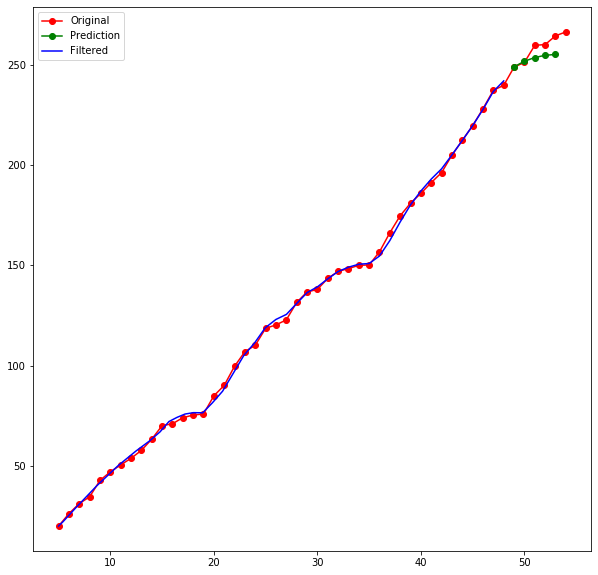

In [52]:
plt.figure(1)
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(x, y, 'ro-') #original
plt.plot(xp, yp, 'go-') #predicted kalman
plt.plot(xf, yf, 'b') #kalman filter
plt.legend( ('Original', 'Prediction', 'Filtered') ) 
plt.show()